In [1]:
import wandb

wandb.login()

wandb: Currently logged in as: liudvikas. Use `wandb login --relogin` to force relogin


True

In [7]:
import os
import json

# Input and output paths
input_json_path = './dataset/train.json'
base_path = '/hpi/fs00/scratch/alexandra.kudaeva/street-view-data/output/G340890_50m'
output_full_json_path = './dataset/train.json'
output_changed_json_path = './dataset/changed_val.json'

# Load the JSON file
with open(input_json_path, 'r') as f:
    data = json.load(f)

# Initialize lists for full data and changed data
updated_data = []
changed_data = []

# Process each image property
for item in data:
    if 'image' in item:
        image_name = item['image']
        # Extract the first three characters for subfolders
        subfolders = "/".join(list(image_name[:3]))
        # Construct the new path
        full_path = os.path.join(base_path, subfolders, image_name)
        # Update the image property
        updated_item = item.copy()
        updated_item['image'] = full_path
        updated_data.append(updated_item)
        
        # Append only the changed property
        changed_data.append({'image': full_path})
    else:
        # Append unmodified item if 'image' does not exist
        updated_data.append(item)

# Save the updated full JSON
with open(output_full_json_path, 'w') as f:
    json.dump(updated_data, f, indent=4)


In [6]:
import tracemalloc
tracemalloc.start()

In [8]:
!deepspeed LLaVA/llava/train/train_xformers.py \
    --lora_enable True --lora_r 64 --lora_alpha 128 --mm_projector_lr 2e-5 \
    --deepspeed LLaVA/scripts/zero3.json \
    --model_name_or_path liuhaotian/llava-v1.5-7b \
    --version v1 \
    --data_path ./dataset/train.json \
    --image_folder / \
    --vision_tower openai/clip-vit-large-patch14-336 \
    --mm_projector_type mlp2x_gelu \
    --mm_vision_select_layer -2 \
    --mm_use_im_start_end False \
    --mm_use_im_patch_token False \
    --image_aspect_ratio pad \
    --group_by_modality_length True \
    --bf16 False \
    --fp16 True \
    --output_dir ./checkpoints/llava-v1.5-7b-task-lora \
    --num_train_epochs 1 \
    --per_device_train_batch_size 1 \
    --per_device_eval_batch_size 1 \
    --gradient_accumulation_steps 1 \
    --evaluation_strategy "no" \
    --save_strategy "steps" \
    --save_steps 50000 \
    --save_total_limit 1 \
    --learning_rate 2e-4 \
    --weight_decay 0. \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 1 \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --dataloader_num_workers 4 \
    --lazy_preprocess True \
    --report_to wandb

[2025-01-21 00:33:04,878] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-01-21 00:33:07,438] [WARNING] [runner.py:202:fetch_hostfile] Unable to find hostfile, will proceed with training with local resources only.
[2025-01-21 00:33:07,439] [INFO] [runner.py:571:main] cmd = /usr/bin/python3 -u -m deepspeed.launcher.launch --world_info=eyJsb2NhbGhvc3QiOiBbMCwgMSwgMiwgM119 --master_addr=127.0.0.1 --master_port=29500 --enable_each_rank_log=None LLaVA/llava/train/train_xformers.py --lora_enable True --lora_r 64 --lora_alpha 128 --mm_projector_lr 2e-5 --deepspeed LLaVA/scripts/zero3.json --model_name_or_path liuhaotian/llava-v1.5-7b --version v1 --data_path ./dataset/train.json --image_folder / --vision_tower openai/clip-vit-large-patch14-336 --mm_projector_type mlp2x_gelu --mm_vision_select_layer -2 --mm_use_im_start_end False --mm_use_im_patch_token False --image_aspect_ratio pad --group_by_modality_length True --bf16 False --fp16 True --

In [4]:
!python3 LLaVA/llava/eval/run_llava.py \
--model-path liuhaotian/llava-v1.5-7b \
--image-file /hpi/fs00/scratch/alexandra.kudaeva/street-view-data/output/G340890_50m/8/8/7/887ia50LZo1d7Hh_anTLOQ_right.webp \
--query "How many meters is the bench away, rounded to the next meter?"

[2025-01-20 18:24:31,244] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|████████████████

In [10]:
import json
import re
import subprocess
import os
import sys
import pandas as pd  # <-- import pandas

def parse_distance(text):
    """
    Extract the first integer found in the text.
    You can adjust this logic depending on how
    the model typically formats its numeric answers.
    """
    match = re.search(r"(\d+)", text)
    if match:
        return int(match.group(1))
    return None

def main():
    # Path to your test dataset
    test_data_path = "dataset/test.json"
    
    # Path to your model
    model_path = "liuhaotian/llava-v1.5-7b"
    
    # Load the dataset
    with open(test_data_path, "r") as f:
        test_data = json.load(f)
    
    # Keep track of errors
    errors = []
    
    # Prepare a list to collect DataFrame rows
    df_rows = []

    for item in test_data:
        # Get the relative image path from the JSON
        relative_image_path = item["image"]
        image_file = relative_image_path
        
        # The question is the human turn
        question = item["conversations"][0]["value"]
        
        # The ground-truth answer is the GPT turn
        ground_truth_str = item["conversations"][1]["value"]
        
        # Parse the ground-truth integer distance
        ground_truth_dist = parse_distance(ground_truth_str)
        if ground_truth_dist is None:
            print(f"Warning: Could not parse distance from ground truth: {ground_truth_str}")
            continue
        
        # Construct command to run LLaVA's run_llava.py
        command = [
            "python3",
            "LLaVA/llava/eval/run_llava.py",
            "--model-path", model_path,
            "--image-file", image_file,
            "--query", question
        ]

        try:
            output = subprocess.check_output(command, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            print(f"Error running inference for {item['id']}. Skipping.\nError: {e.output.decode('utf-8')}")
            continue

        all_output = output.decode("utf-8")
        lines = all_output.strip().split("\n")

        # The model's answer should be on the last line
        model_output_line = lines[-1]

        predicted_dist = parse_distance(model_output_line)
        
        if predicted_dist is None:
            print(f"Warning: Could not parse distance from model output: {model_output_line}")
            continue
        
        # Compute absolute difference
        error = abs(predicted_dist - ground_truth_dist)
        errors.append(error)
        
        print(f"ID: {item['id']}")
        print(f"  Question: {question}")
        print(f"  Ground truth: {ground_truth_dist} meters")
        print(f"  Model answer: {model_output_line}")
        print(f"  Parsed Model answer: {predicted_dist} meters")
        print(f"  Error: {error}\n")

        # Append row for the DataFrame
        df_rows.append({
            "id": item["id"],
            "question": question,
            "ground_truth": ground_truth_dist,
            "predicted": predicted_dist,
            "error": error
        })
    
    # Compute average error
    if len(errors) > 0:
        average_error = sum(errors) / len(errors)
        print(f"Average error across {len(errors)} samples: {average_error:.2f} meters")
    else:
        print("No valid predictions found to compute error.")
    
    # Create a DataFrame from results
    df = pd.DataFrame(df_rows)
    print("\nResults DataFrame:")
    print(df)

   
    df.to_csv("llava_results_pre.csv", index=False)

if __name__ == "__main__":
    main()


ID: zHTQOrYONrL49SD3ouBwAA_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 11 meters
  Model answer: The bench is approximately 20 meters away from the camera.
  Parsed Model answer: 20 meters
  Error: 9

ID: AugnHJNeLQOFo_kgizi_Og_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 11 meters
  Model answer: The bench is approximately 10 meters away from the camera.
  Parsed Model answer: 10 meters
  Error: 1

ID: QJeB288kJcLHPPzNjkVtHg_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 21 meters
  Model answer: The bench is approximately 10 meters away from the camera, rounded to the next meter.
  Parsed Model answer: 10 meters
  Error: 11

ID: 4-P_5vju1cJmYjFZVJAA1Q_left
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 13 meters
  Model a

In [ ]:
!python run_llava.py --model-path /root/LLaVA/llava/checkpoints/llava-2-7b-chat-task-qlora/best_llava_eval_model_llava_lora 
--model-base /root/LLaVA/llava/llava-v1.5-7b 
--image-file /root/dataset/images/0f47c0b5-2c77-45e6-87b0-89af46e99500.jpg 
--query “why was this photo taken?”

In [3]:
!python3 LLaVA/scripts/merge_lora_weights.py \
--model-path checkpoints/llava-v1.5-7b-task-lora \
--model-base liuhaotian/llava-v1.5-7b \
--save-model-path llava-ftmodel

[2025-01-21 21:39:09,842] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading LLaVA from base model...
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████████████| 2/2 [00:03<00:00,  1.77s/it]
Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model i

In [4]:
import json
import re
import subprocess
import os
import sys
import pandas as pd

def parse_distance(text):
    """
    Extract the first integer found in the text.
    You can adjust this logic depending on how
    the model typically formats its numeric answers.
    """
    match = re.search(r"(\d+)", text)
    if match:
        return int(match.group(1))
    return None

def main():
    # Path to your test dataset
    test_data_path = "dataset/test.json"
    
    # Path to your model
    model_base = "liuhaotian/llava-v1.5-7b"
    model_path = "checkpoints/llava-v1.5-7b-task-lora"
    
    # Load the dataset
    with open(test_data_path, "r") as f:
        test_data = json.load(f)
    
    # Keep track of errors
    errors = []
    
    # Prepare a list to collect DataFrame rows
    df_rows = []

    for item in test_data:
        # Get the relative image path from the JSON
        relative_image_path = item["image"]
        image_file = relative_image_path
        
        # The question is the human turn
        question = item["conversations"][0]["value"]
        
        # The ground-truth answer is the GPT turn
        ground_truth_str = item["conversations"][1]["value"]
        
        # Parse the ground-truth integer distance
        ground_truth_dist = parse_distance(ground_truth_str)
        if ground_truth_dist is None:
            print(f"Warning: Could not parse distance from ground truth: {ground_truth_str}")
            continue
        
        # Construct command to run LLaVA's run_llava.py
        command = [
            "python3",
            "LLaVA/llava/eval/run_llava.py",
            "--model-base", model_base,
            "--model-path", model_path,
            "--image-file", image_file,
            "--query", question
        ]

        try:
            output = subprocess.check_output(command, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            print(f"Error running inference for {item['id']}. Skipping.\nError: {e.output.decode('utf-8')}")
            continue

        all_output = output.decode("utf-8")
        lines = all_output.strip().split("\n")

        # The model's answer should be on the last line
        model_output_line = lines[-1]

        predicted_dist = parse_distance(model_output_line)
        
        if predicted_dist is None:
            print(f"Warning: Could not parse distance from model output: {model_output_line}")
            continue
        
        # Compute absolute difference
        error = abs(predicted_dist - ground_truth_dist)
        errors.append(error)
        
        print(f"ID: {item['id']}")
        print(f"  Question: {question}")
        print(f"  Ground truth: {ground_truth_dist} meters")
        print(f"  Model answer: {model_output_line}")
        print(f"  Parsed Model answer: {predicted_dist} meters")
        print(f"  Error: {error}\n")

        # Append row for the DataFrame
        df_rows.append({
            "id": item["id"],
            "question": question,
            "ground_truth": ground_truth_dist,
            "predicted": predicted_dist,
            "error": error
        })
    
    # Compute average error
    if len(errors) > 0:
        average_error = sum(errors) / len(errors)
        print(f"Average error across {len(errors)} samples: {average_error:.2f} meters")
    else:
        print("No valid predictions found to compute error.")
    
    # Create a DataFrame from results
    df = pd.DataFrame(df_rows)
    print("\nResults DataFrame:")
    print(df)

   
    df.to_csv("llava_results_after.csv", index=False)

if __name__ == "__main__":
    main()


ID: zHTQOrYONrL49SD3ouBwAA_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 11 meters
  Model answer: 11 meters
  Parsed Model answer: 11 meters
  Error: 0

ID: AugnHJNeLQOFo_kgizi_Og_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 11 meters
  Model answer: 11 meters
  Parsed Model answer: 11 meters
  Error: 0

ID: QJeB288kJcLHPPzNjkVtHg_right
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 21 meters
  Model answer: 22 meters
  Parsed Model answer: 22 meters
  Error: 1

ID: 4-P_5vju1cJmYjFZVJAA1Q_left
  Question: How far is the bench away from the camera in meters, rounded to the next meter?
  Ground truth: 13 meters
  Model answer: 16 meters
  Parsed Model answer: 16 meters
  Error: 3

ID: pP-PfrSj-5XNh3AaWzHyPA_front
  Question: How far is the bench away from the camera in meters, rounded to the 

Pre summary:
 count    86.000000
mean      7.011628
std       5.821854
min       0.000000
25%       2.000000
50%       6.500000
75%      10.750000
max      20.000000
Name: error, dtype: float64 

After summary:
 count    86.000000
mean      5.616279
std       5.071648
min       0.000000
25%       2.000000
50%       4.000000
75%       8.000000
max      19.000000
Name: error, dtype: float64 



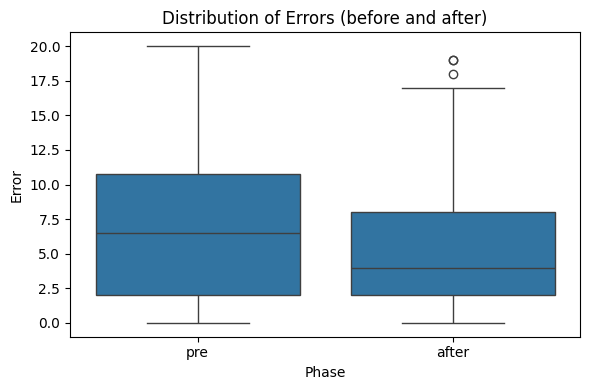

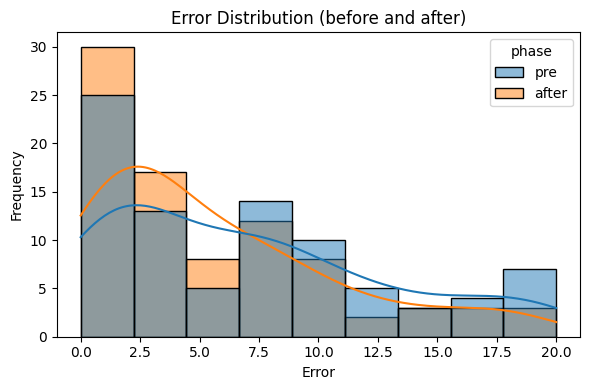

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df_pre = pd.read_csv("llava_results_pre.csv")
df_after = pd.read_csv("llava_results_after.csv")

df_pre["phase"] = "pre"
df_after["phase"] = "after"

df_combined = pd.concat([df_pre, df_after], ignore_index=True)

print("Pre summary:\n", df_pre["error"].describe(), "\n")
print("After summary:\n", df_after["error"].describe(), "\n")

plt.figure(figsize=(6, 4))
sns.boxplot(x="phase", y="error", data=df_combined)
plt.title("Distribution of Errors (before and after)")
plt.ylabel("Error")
plt.xlabel("Phase")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(data=df_combined, x="error", hue="phase", kde=True)
plt.title("Error Distribution (before and after)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


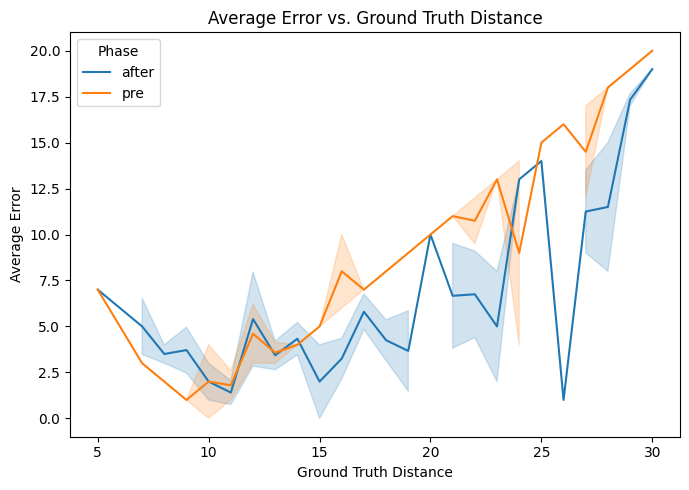

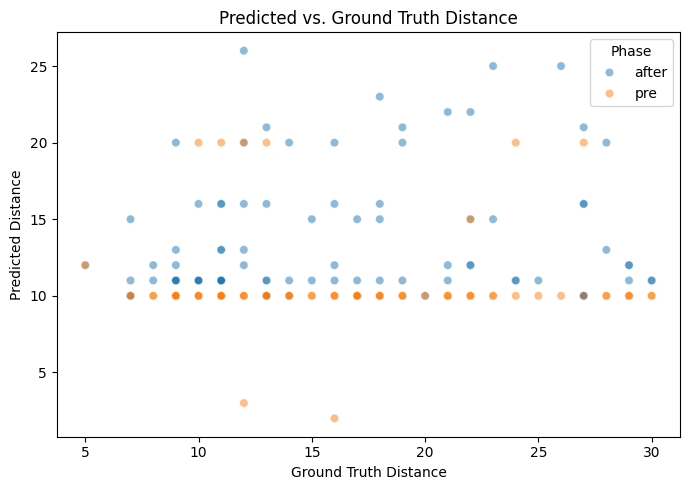

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_pre = pd.read_csv("llava_results_pre.csv")
df_after = pd.read_csv("llava_results_after.csv")

df_pre["phase"] = "pre"
df_after["phase"] = "after"

df = pd.concat([df_pre, df_after], ignore_index=True)

df = df.sort_values(by="ground_truth")

plt.figure(figsize=(7, 5))
sns.lineplot(
    data=df,
    x="ground_truth", 
    y="error",
    hue="phase",
    estimator="mean",  
    errorbar="se"     
)
plt.title("Average Error vs. Ground Truth Distance")
plt.xlabel("Ground Truth Distance")
plt.ylabel("Average Error")
plt.legend(title="Phase")
plt.tight_layout()
plt.show()
